# Analyzing Toronto house price using python(jupyter notebook)

In [1]:
import re
import time
import requests
from bs4 import BeautifulSoup
from requests_html import HTMLSession
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator
import seaborn as sns

In [2]:
# initalize the tables
df = pd.DataFrame(columns=['Price', 'Bedroom', 'Bathroom', 'Address', 'Postal Code', 'Forward Sortation Area', 'Road Type'])

# Create a dictionary to map road type indicators to address types
road_type_mapping = {
    "Rd": "Road",
    "Ave": "Avenue",
    "Blvd": "Boulevard",
    "St": "Street",
    "Dr": "Drive"
}

# initalize a session for web scraping
session = HTMLSession()
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.63 Safari/537.36"
}

In [3]:
# price formatter
def price_formatter(x, pos):
    return f'${x:,.0f}'

In [4]:
# fetch and write data into tables
# due to the request limit, we will only fetch limited data from zillow
for page in range(1,21):
    r = session.get("https://www.zillow.com/toronto-on/{}_p/".format(page), headers=headers)
    # parse the content
    soup = BeautifulSoup(r.text,'html.parser')
    properties = soup.find_all("div",{"class":"property-card-data"})
    sizes = soup.find_all("ul",{"class":"eYPFID"})
    
    for i in range(0,len(properties)):
        try:
            price = int(re.search(r'\d+(,\d+)*', properties[i].find("span",{"class":"iMKTKr"}).text).group().replace(',', ''))
        except:
            price = None
        try:
            bedroom = int(re.search(r'\d+(,\d+)*', properties[i].find("ul",{"class":"eYPFID"}).contents[0].text).group().replace(',', ''))
        except:
            bedroom = None
        try:
            bathroom = int(re.search(r'\d+(,\d+)*', properties[i].find("ul",{"class":"eYPFID"}).contents[1].text).group().replace(',', ''))
        except:
            bathroom = (None)
        try:
            address = re.sub(r' [A-Z]\d[A-Z] \d[A-Z]\d$', '', properties[i].find("a",{"class":"property-card-link"}).text)
        except:
            address = None
        try:
            postal_code = re.search(r'([A-Z][0-9][A-Z]) [0-9][A-Z][0-9]', properties[i].find("a",{"class":"property-card-link"}).text).group()
            forward_sortation_area = postal_code.split()[0]
        except:
            postal_code = None
            forward_sortation_area = None
        try:
            components = re.sub(r' [A-Z]\d[A-Z] \d[A-Z]\d$', '', properties[i].find("a",{"class":"property-card-link"}).text).split(',')
            street_part = components[0].strip()
            words = street_part.split()
            road_type = None
            
            for word in words:
                if word in road_type_mapping:
                    road_type = word
                    break
            
            if road_type:
                road_type = road_type_mapping[road_type]
            else:
                road_type = "Unknown"
        except:
            road_type = None

        # concatenate the data to the dataframe
        new_df = pd.DataFrame([[price, bedroom, bathroom, address, postal_code, forward_sortation_area, road_type]], columns=['Price', 'Bedroom', 'Bathroom', 'Address', 'Postal Code', 'Forward Sortation Area', 'Road Type'])
        df = pd.concat([df, new_df], ignore_index=True)

In [5]:
# print the web page title
soup.title.text

'Toronto ON Real Estate - Toronto ON Homes For Sale | Zillow'

In [6]:
# remove rows with invalid bedroom data (None)
df = df.dropna(subset=['Bedroom'])
df = df.dropna(subset=['Bathroom'])

# Convert 'Price', 'Bedroom', and 'Bathroom' columns to numeric data types
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Bedroom'] = pd.to_numeric(df['Bedroom'], errors='coerce')
df['Bathroom'] = pd.to_numeric(df['Bathroom'], errors='coerce')

In [7]:
# display the dataframe to have a comprehensive look
df

,Price,Bedroom,Bathroom,Address,Postal Code,Forward Sortation Area,Road Type
0,1198800,3,2,"2494 Lake Shore Blvd W, Toronto, ON",M8V 1E1,M8V,Boulevard
1,974999,3,3,"2 Lippincott St E #2B, Toronto, ON",M9N 1B1,M9N,Street
2,999000,4,3,"664 Pape Ave, Toronto, ON",M4K 3S5,M4K,Avenue
3,1399000,4,2,"55 Barkwin Dr, Toronto, ON",M9V 2W5,M9V,Drive
4,1199000,3,2,"164 Munro St, Toronto, ON",M4M 2B9,M4M,Street
...,...,...,...,...,...,...,...
175,779900,4,3,"50 Verne Cres #53, Toronto, ON",M1B 2X1,M1B,Unknown
176,699900,2,2,"20 Thomas Riley Rd W #1507, Toronto, ON",M9B 0C3,M9B,Road
177,4480000,4,6,"142 Upper Canada Dr, Toronto, ON",M2P 1S8,M2P,Drive
178,485000,1,1,"114 Vaughan Rd #402, Toronto, ON",M6C 2M1,M6C,Road


### Price Distribution by Bedroom Count
Visualize how the housing prices are distributed based on the number of bedrooms using a histogram.

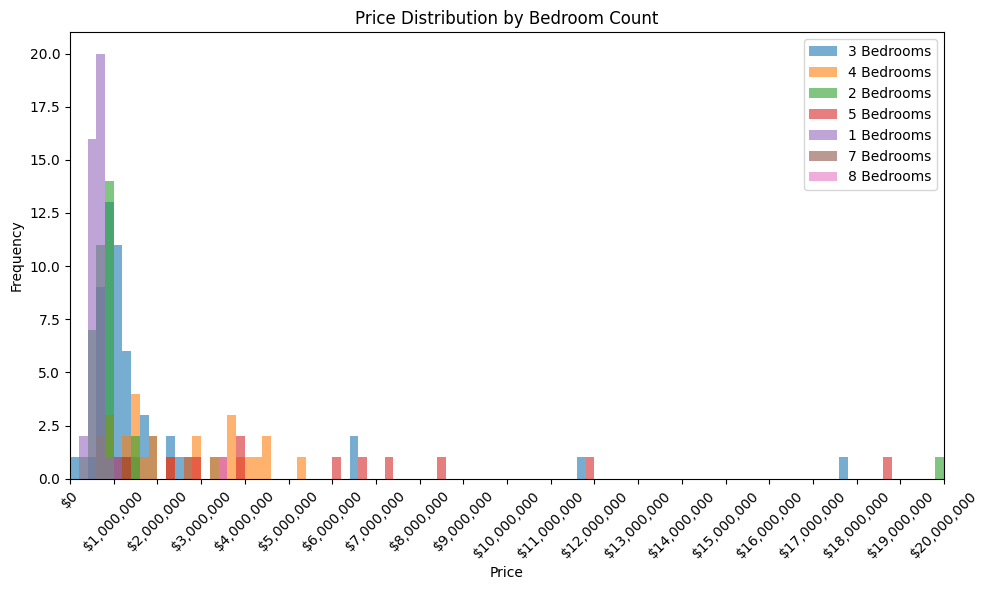

In [8]:
# analyze and visualize the data
plt.figure(figsize=(10, 6))
bins = np.arange(0, df['Price'].max() + 500000, 200000)  # Adjust bin width for denser bins
for bedroom_count in df['Bedroom'].unique():
    data = df[df['Bedroom'] == bedroom_count]['Price']
    plt.hist(data, bins=bins, alpha=0.6, label=f'{bedroom_count} Bedrooms')
plt.title('Price Distribution by Bedroom Count')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.xticks(rotation=45)

plt.gca().xaxis.set_major_formatter(FuncFormatter(price_formatter))
plt.gca().xaxis.set_major_locator(MultipleLocator(base=1000000))

# adjust the x-axis limits for better visualization of the price distribution
plt.xlim(0, 20000000)

plt.tight_layout()
plt.show()

The histogram portrays a housing market where the bulk of properties are priced below 1 million dollars, emphasizing the prominent emphasis on affordability in property pricing. These insights can prove invaluable for both prospective homebuyers and real estate professionals seeking to understand the distribution of prices within the market.

### Price by Road Type: Violin Plot
The violin plot will show the distribution of prices for each road type, including information about the median, spread, and density of prices.

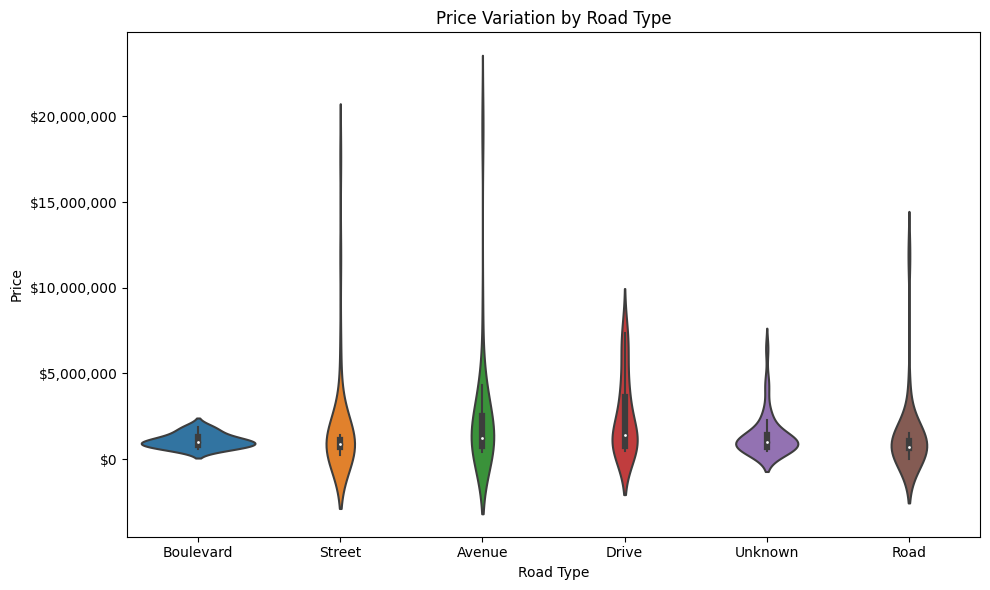

In [9]:
# Violin Plot: Price by Address Type
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Road Type', y='Price')
plt.title('Price Variation by Road Type')
plt.xlabel('Road Type')
plt.ylabel('Price')
plt.gca().yaxis.set_major_formatter(FuncFormatter(price_formatter))
plt.tight_layout()
plt.show()

In the violin plot analysis of price variation by address type, we observe that the lower quartiles of most address types are quite consistent, indicating similar starting price points. However, significant distinctions arise in the upper quartiles, with "avenue" and "drive" displaying notably higher values among all the road types. Notably, the upper quartile of "drive" exceeds that of "avenue," suggesting a higher upper price range for properties located on "drive" streets. Although outliers are evident in the "street," "avenue," and "road" categories, the "drive" type consistently stands out with comparatively higher prices. These observations could potentially be attributed to factors such as location, property size, local amenities, or desirability, which contribute to the varying pricing trends across different address types.

### Top 5 Areas by Forward Sortation Area
Identify the top 5 areas with the highest average prices based on Forward Sortation Area (FSA).

In [10]:
# Calculate the mean prices for each Forward Sortation Area, sort them in descending order, and select the top 5 areas.
top_areas = df.groupby('Forward Sortation Area')['Price'].mean().sort_values(ascending=False).head(5)

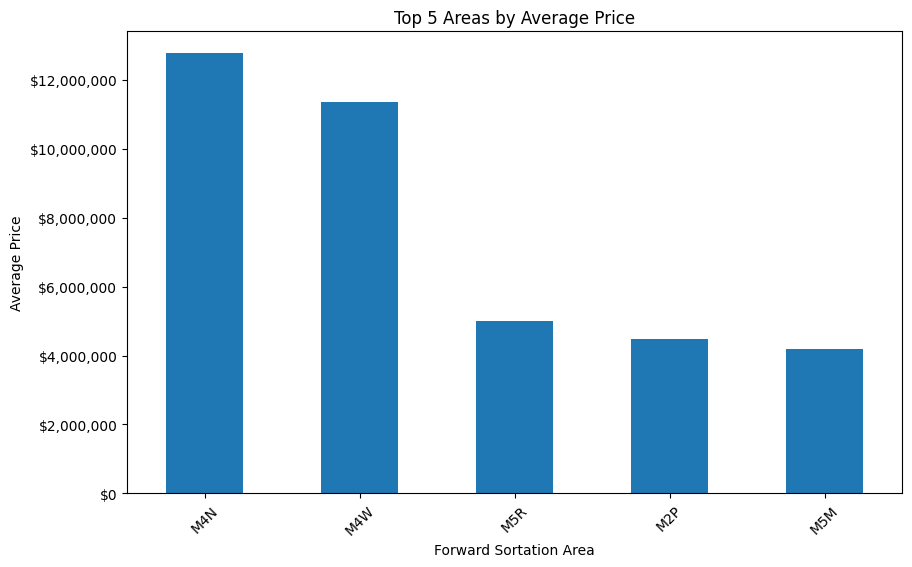

In [11]:
# analyze and visualize the data
plt.figure(figsize=(10, 6))
top_areas.plot(kind='bar')
plt.title('Top 5 Areas by Average Price')
plt.xlabel('Forward Sortation Area')
plt.ylabel('Average Price')
plt.gca().yaxis.set_major_formatter(FuncFormatter(price_formatter))
plt.xticks(rotation=45)
plt.show()

The analysis has divulged intriguing insights, highlighting the top 5 areas with the most elevated average prices: M4N, M4W, M5R, M2P, M5M. To provide a deeper understanding, let's delve into each area along with specific examples:

- M4N: The presence of elevated average prices in this area could be exemplified by exclusive attributes such as proximity to renowned private schools, tree-lined streets, and historic architecture.

- M4W: The higher average prices in M4W could be attributed to its central downtown location, offering luxurious penthouses with stunning skyline views and convenient access to cultural hubs.

- M5R: M5R's elevated average prices may stem from its Victorian-era charm, cultural venues, and trendy boutiques. Victorian-style townhouses and restored heritage homes could contribute to the higher property values.

- M2P: The M2P area commands premium prices for its spacious properties on large lots. Luxurious finishes and proximity to esteemed golf clubs enhance its allure, creating an exclusive and leisurely environment.

- M5M: Known for upscale living and convenience, M5M sustains its premium prices. It offers a diverse array of high-end properties, from elegant homes to sophisticated condos. Well-regarded schools, chic shopping, and recreational spaces amplify its desirability for discerning home seekers.

These observations collectively suggest that the identified areas command higher prices due to their unique attributes, which cater to specific preferences and lifestyles. The discerned patterns offer valuable insights for real estate stakeholders, aiding in investment decisions, market analysis, and comprehending the drivers behind property valuation in these distinct locales.

### Price Correlation with Bedroom and Bathroom Counts: Scatter Plot Matrix
This scatter plot matrix will display scatter plots for each combination of the variables (Price, Bedroom, and Bathroom), allowing us to visually inspect potential correlations.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/9d/bcgtcpbd4lq21mm354vr45cc0000gn/T/ipykernel_51015/4255072443.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

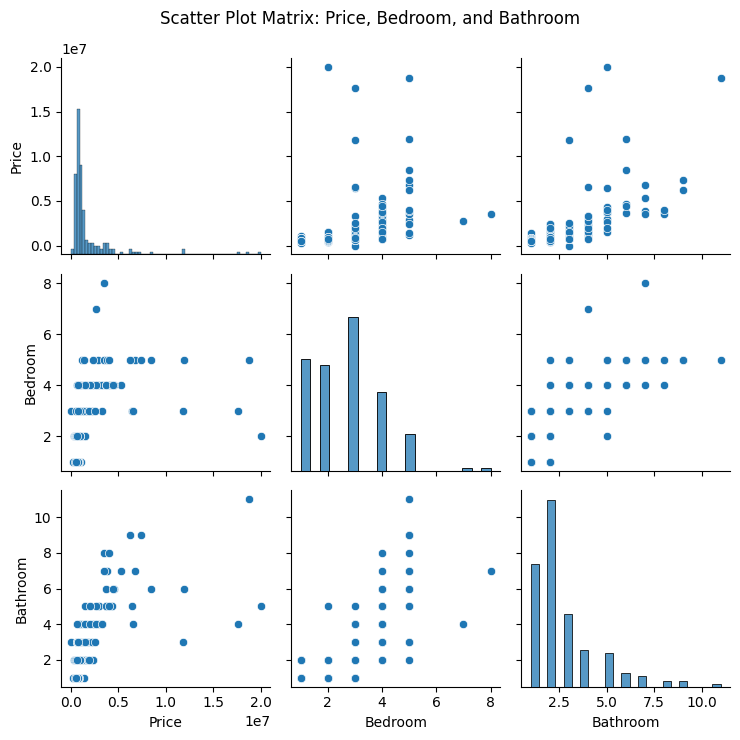

In [12]:
# Scatter Plot Matrix
plt.figure(figsize=(10, 6))
sns.pairplot(df, vars=['Price', 'Bedroom', 'Bathroom'])
plt.suptitle('Scatter Plot Matrix: Price, Bedroom, and Bathroom')
plt.tight_layout()
plt.show()

### Scatter Plot of Price vs Bedroom and Bathroom Counts
Visualize the relationship between house prices, bedroom counts, and bathroom counts using a scatter plot.

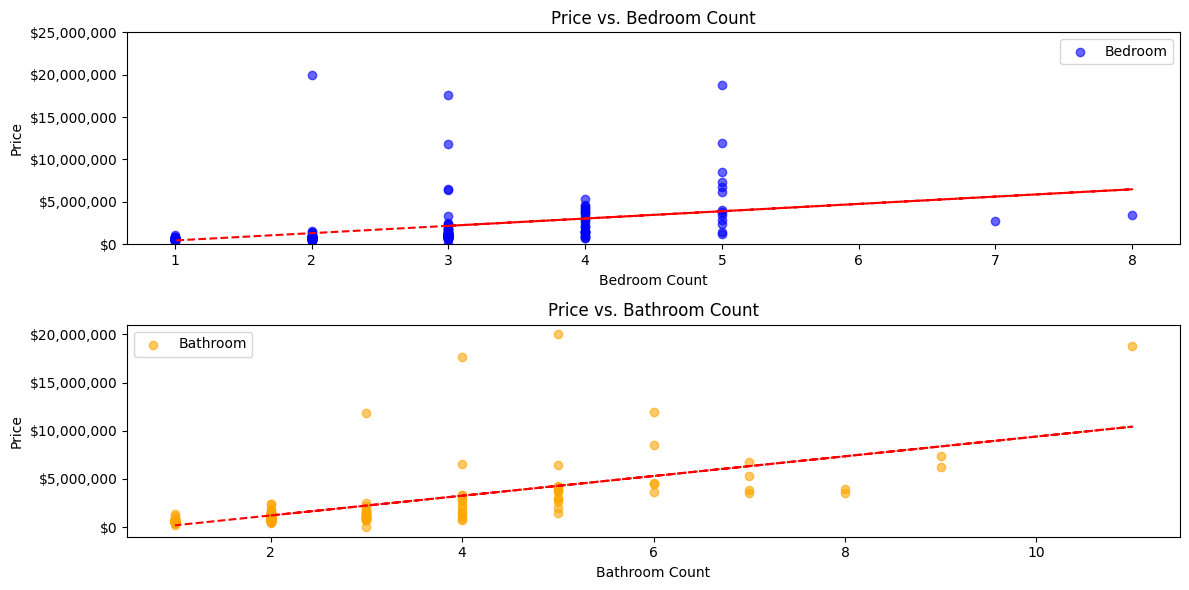

In [13]:
# Analyze and visualize the data
plt.figure(figsize=(12, 6))

# Scatter Plot: Price vs. Bedroom Count
plt.subplot(2, 1, 1)
plt.scatter(df['Bedroom'], df['Price'], c='blue', label='Bedroom', alpha=0.6)
z = np.polyfit(df['Bedroom'], df['Price'], 1)
p = np.poly1d(z)
plt.plot(df['Bedroom'], p(df['Bedroom']), "r--")
plt.title('Price vs. Bedroom Count')
plt.xlabel('Bedroom Count')
plt.ylabel('Price')
plt.gca().yaxis.set_major_formatter(FuncFormatter(price_formatter))
plt.ylim(0, 25000000)
plt.legend()

# Scatter Plot: Price vs. Bathroom Count
plt.subplot(2, 1, 2)
plt.scatter(df['Bathroom'], df['Price'], c='orange', label='Bathroom', alpha=0.6)
z = np.polyfit(df['Bathroom'], df['Price'], 1)
p = np.poly1d(z)
plt.plot(df['Bathroom'], p(df['Bathroom']), "r--")
plt.title('Price vs. Bathroom Count')
plt.xlabel('Bathroom Count')
plt.ylabel('Price')
plt.gca().yaxis.set_major_formatter(FuncFormatter(price_formatter))
plt.legend()

plt.tight_layout()
plt.show()

Both graphs showcase positive correlations between property prices and bedroom/bathroom counts. The steeper slope in the bathroom graph indicates that bathrooms might have a slightly stronger influence on property prices than bedrooms, possibly due to the luxury and convenience they provide. These insights can be invaluable for real estate market analysis, guiding buyers, sellers, and investors in understanding the factors influencing property values.

### Conclusion

##### Introduction and Affordability Trends:
This data analytics project delves into the Toronto housing market, unraveling key insights to guide both prospective homebuyers and real estate professionals. The initial analysis, represented through histograms, underscores a prevailing emphasis on affordability. The majority of properties are priced below 1 million dollars, providing a significant observation that sets the stage for understanding the broader market dynamics. This foundational insight equips stakeholders with a clear picture of the distribution of prices, essential for making informed decisions in the real estate landscape.

##### Address-Specific Pricing Patterns and Premium Areas:
The subsequent phase of analysis examines address-specific pricing patterns using violin plots. While the lower quartiles across various address types exhibit consistency in starting prices, the upper quartiles reveal intriguing disparities. Properties located on "avenue" and "drive" streets stand out with notably higher values, with "drive" surpassing "avenue." This differentiation suggests a complex interplay of factors, including location, property size, amenities, and desirability, influencing diverse pricing trends. Moving forward, the identification of premium areas with elevated average prices, such as M4N, M4W, M5R, M2P, and M5M, brings into focus the significance of unique attributes. From luxury estates and prestigious schools to central downtown locations and historical charm, these areas command higher prices due to distinct features that resonate with specific preferences and lifestyles.

##### Address-Specific Pricing Patterns and Premium Areas:
The project concludes by investigating correlations between property prices and bedroom/bathroom counts. This analysis reveals a positive relationship, with bathrooms exhibiting a slightly stronger impact than bedrooms on property values. The luxury and convenience associated with bathrooms contribute to this trend. These findings offer practical implications for market analysis, guiding buyers, sellers, and investors in understanding the influential factors shaping property values. In sum, this comprehensive data analytics project enriches the comprehension of Toronto's real estate landscape, offering insights that span affordability, address-based pricing dynamics, premium locales, and the role of bedroom/bathroom counts. This holistic understanding serves as an invaluable resource for navigating the nuanced Toronto property market and making informed real estate decisions.

Through a comprehensive analysis of Toronto's housing market, this project reveals key insights. The market emphasizes affordability, with a majority of properties priced below 1 million dollars. Road types exhibit diverse pricing trends, driven by factors like location and desirability. Specific premium areas command higher prices due to unique attributes, aiding investment decisions. Bedrooms and bathrooms positively impact property values, with bathrooms showing a slightly stronger influence. These findings collectively provide a valuable resource for understanding and navigating Toronto's dynamic real estate landscape.